# Question 1

## (i)

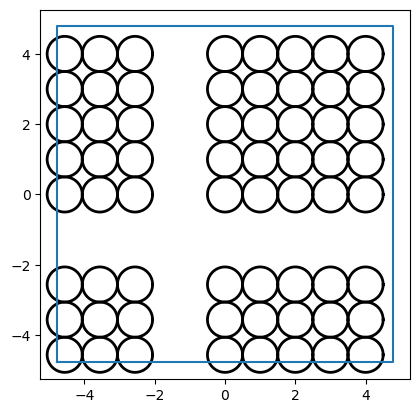

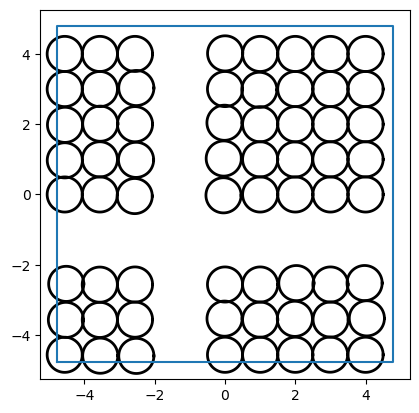

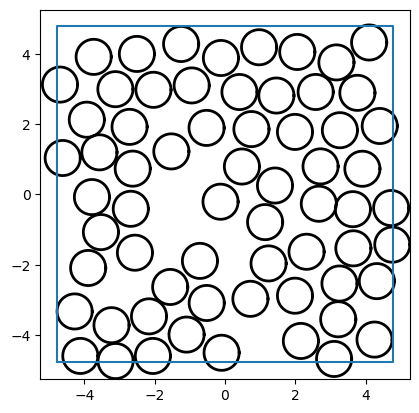

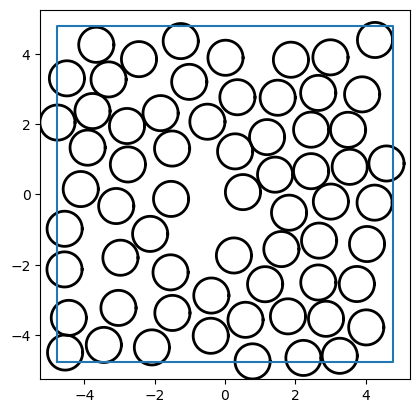

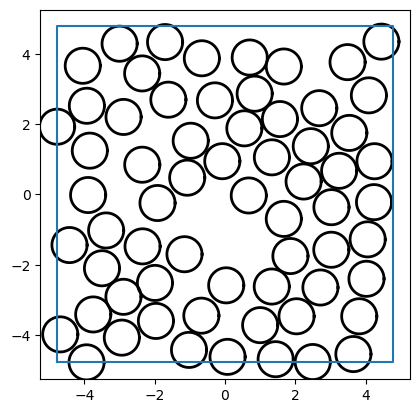

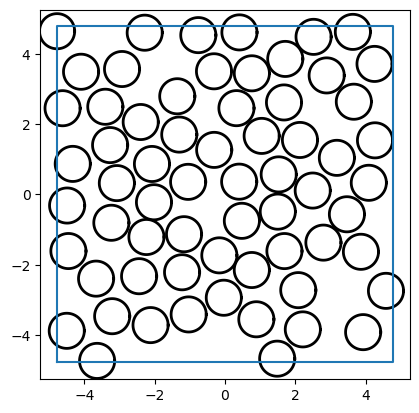

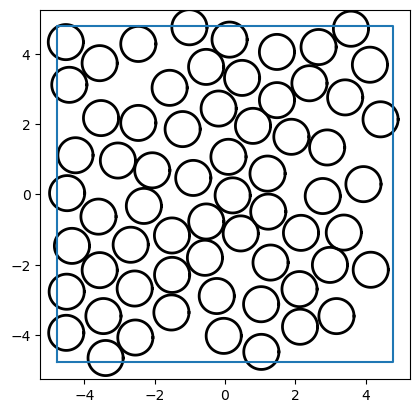

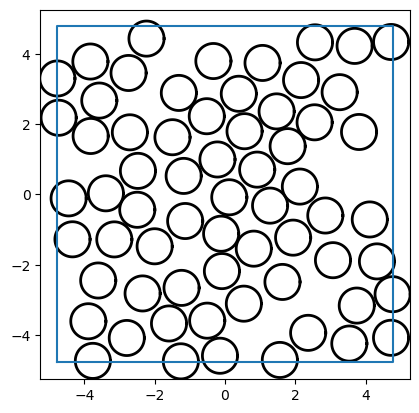

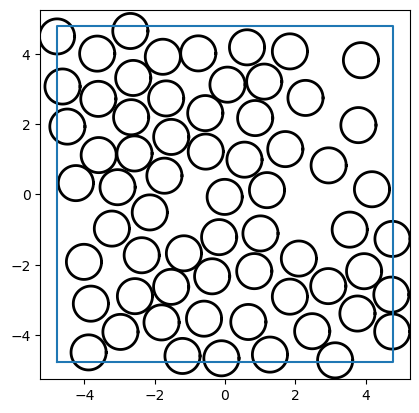

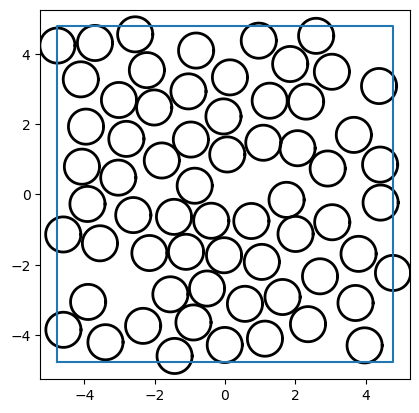

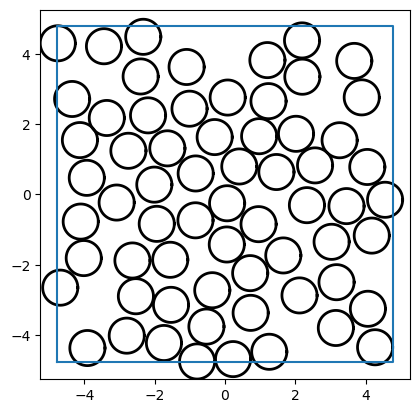

In [87]:
# import packages for basic math, plotting, linear algebra, etc.
from numpy import *
from numpy import minimum as min
from numpy.linalg import *
from numpy.random import *
from matplotlib.pyplot import *
from scipy.special import binom, erf, erfc

class histogram(): # histogram class
    def __init__(self,limits,binwidth):
        self.limits = limits
        self.binwidth = binwidth
        self.vals = arange(self.limits[0] + self.binwidth / 2, self.limits[1], self.binwidth)  
        self.histo = 0 * self.vals  
        self.N_samples = 0  

    def add_sample(self,dat):
        self.N_samples += 1
        if dat > self.limits[0] and dat < self.limits[1]:
            bin_index = int((dat - self.limits[0]) / self.binwidth)  
            self.histo[bin_index] += 1  

    def normalize(self):
        self.histo = self.histo / (self.N_samples * self.binwidth)

    def barplot(self):
        bar(self.vals, self.histo, width=0.95 * self.binwidth, color='k')
        
    def lineplot(self):
        plot(self.vals, self.histo)

def plot_circle(center,radius): # plot circles
    npoints = 100  # Number of points to approximate the circle
    theta = arange(0,2*pi + 1e-7,2*pi/npoints)  # Angular positions around circle
    x = center[0] + radius*cos(theta)  
    y = center[1] + radius*sin(theta)  
    plot(x,y,'k',linewidth=2) 

def init_config(): # define initial configuration
    r = zeros((N, 2))  # Initialize position array
    n_side = int(sqrt(N) + 0.99)  # Calculate number of particles per side, rounding up
    count = 0
    for row in range(n_side):
        for column in range(n_side):
            if count < N:
                r[count, :] = [row, column]  # Place particle at grid position
                count += 1

    return r

def draw_config(): # draw particle configuration 
    clf()  
    for i in range(N):
        # Apply periodic boundary conditions to keep particles in the box
        r[i,:] -= box_length * floor(r[i,:]/box_length + 0.5)
        plot_circle(r[i, :], 0.5)  # Draw each particle as a circle
    axis('equal') 
    gca().set_adjustable("box")
    view_scale = 1.1*box_length/2
    xlim(-view_scale, view_scale)  
    ylim(-view_scale, view_scale) 

    # Draw the simulation box boundary
    boundary_x = box_length * (array([0,1,1,0,0]) - 0.5)
    boundary_y = box_length * (array([0,0,1,1,0]) - 0.5)
    plot(boundary_x,boundary_y)

    pause(0.01)  # Pause for visualization

# Simulation parameters
N = 64  # Number of particles
T = 0.5  # Temperature (in reduced units)
density = 0.7  # Number density of particles
box_length = sqrt(N/density)  # Calculate box length

max_hop_length = 0.1  # Maximum displacement in a Monte Carlo move
r_cut = box_length/2  # Cutoff distance for interactions
r_cut_squared = r_cut**2  # Square of cutoff distance (for efficiency)

r = init_config()
draw_config()  

from numba import jit
@jit(nopython=True)  
def MC_sweep(r):
    for step in range(N):
        i_trial = int(rand()*N)  # Randomly select a particle
        r_trial = r[i_trial,:] + max_hop_length * (rand(2) - 0.5)  # Generate trial move

        delta_U = 0  # Initialize energy change
        for j in range(N):
            if j != i_trial:  # Skip self-interaction
                # Calculate separation vector for trial position (with periodic BC)
                dr_trial = r_trial - r[j,:]
                dr_trial -= box_length * floor(dr_trial/box_length + 0.5)
                dr2_trial = dr_trial @ dr_trial  # Squared distance
                dr2_trial = min(dr2_trial,r_cut_squared)  # Apply cutoff

                # Calculate current separation vector (with periodic BC)
                dr = r[i_trial,:] - r[j,:]
                dr -= box_length * floor(dr/box_length + 0.5)
                dr2 = dr @ dr  # Squared distance
                dr2 = min(dr2,r_cut_squared)  # Apply cutoff

                # Calculate energy change using Lennard-Jones potential
                delta_U += 4*( dr2_trial**(-6) - dr2_trial**(-3) ) \
                    - 4*( dr2**(-6) - dr2**(-3) )

        # Metropolis acceptance criterion
        if rand() < exp(-delta_U / T):
            r[i_trial,:] = r_trial  # Accept the move

    return r

# Main simulation loop
N_sweeps = 10000  # Total number of Monte Carlo sweeps
for sweep in range(N_sweeps):
    r = MC_sweep(r)  # Perform one Monte Carlo sweep

    if sweep % 1000 == 0:  # Visualize every 1000 sweeps
        draw_config()

## (ii)

In [25]:
from tqdm import tqdm

@jit(nopython=True)
def U_total(r):
    U = 0
    for i in range(N):
        for j in range(i+1, N):  
            dr = r[i,:] - r[j,:]
            dr -= box_length * floor(dr/box_length + 0.5)
            dr2 = dr @ dr
            dr2 = min(dr2,r_cut_squared)

            if dr2 < r_cut_squared:
                U += 4*( dr2**(-6) - dr2**(-3) ) - 4*( r_cut_squared**(-6) - r_cut_squared**(-3) )
            
    return U


N = 64  
T = 0.8  
density = 0.7 
box_length = sqrt(N/density)  

max_hop_length = 0.5 
r_cut = box_length/2 
r_cut_squared = r_cut**2 

r = init_config()
U_totals = []

N_sweeps = 10000
for sweep in tqdm(range(N_sweeps)):
    r = MC_sweep(r) 

    if sweep % 100 == 0:
        U_tot = U_total(r)
        U_totals.append(U_tot)

    # if sweep % 1000 == 0:
    #     draw_config()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1765.37it/s]


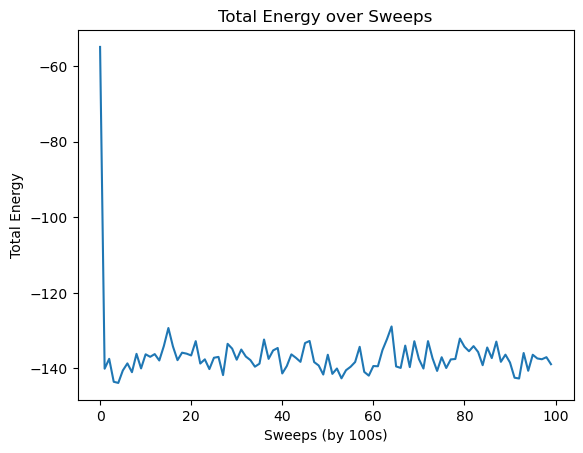

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(range(int(N_sweeps/100)), U_totals)
ax.set_xlabel('Sweeps (by 100s)')
ax.set_ylabel('Total Energy')
ax.set_title('Total Energy over Sweeps')
plt.savefig('Visualizations/1_ii.png')

## (iii)

It takes fewer than a few hundred sweeps to reach equillibrium. 

## (iv)

In [38]:
N = 64  
T = 0.8  
density = 0.7 
box_length = sqrt(N/density)  

max_hop_length = 0.5 
r_cut = box_length/2 
r_cut_squared = r_cut**2 

r = init_config()
U_totals = []

N_sweeps = 100000
for sweep in tqdm(range(N_sweeps)):
    r = MC_sweep(r) 

    U_tot = U_total(r)
    U_totals.append(U_tot)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:18<00:00, 1274.79it/s]


In [58]:
len([t for t in U_totals if t >= -120]) # t_relax gague

59

In [56]:
U_eq_totals = U_totals[500:] # remove first 500 to reach t_relax
U_avg = mean(U_eq_totals)
U_flux = [(t-U_avg)**2 for t in U_totals if t < -120]
U_var = mean(U_flux)

print(f'U_avg: {U_avg}')
print(f'U_var: {U_var}')

U_avg: -136.52255619821062
U_var: 9.679261148005148


## (v)

In [62]:
N = 64  
Ts = [0.8, 0.75, 0.7, 0.65] 
density = 0.7 
box_length = sqrt(N/density)  

max_hop_length = 0.5 
r_cut = box_length/2 
r_cut_squared = r_cut**2 

r = init_config()
T_totals = []

for T in Ts:
    U_totals = []
    N_sweeps = 100000
    for sweep in tqdm(range(N_sweeps)):
        r = MC_sweep(r) 

        U_tot = U_total(r)
        U_totals.append(U_tot)
    T_totals.append(U_totals)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:19<00:00, 1262.74it/s]


In [79]:
U_avgs = []
U_vars = []

for U_totals in T_totals:
    U_eq_totals = U_totals[500:] # remove first 500 to reach t_relax
    U_tot_avg = mean(U_eq_totals)
    U_avg = U_tot_avg / N
    U_flux = [(t-U_tot_avg)**2 for t in U_totals if t < -120]
    U_var = mean(U_flux) / N

    U_avgs.append(U_avg)
    U_vars.append(U_var)

print(U_avgs)
print(U_vars)

[np.float64(-2.1352646804419146), np.float64(-2.1363091150480895), np.float64(-2.1343379747304954), np.float64(-2.1372339564952245)]
[np.float64(0.15237492215431692), np.float64(0.1632349718226835), np.float64(0.16344889747082933), np.float64(0.1665618134710739)]


| T | $\frac{\langle U \rangle}{N}$ | $\frac{\langle \delta U^{2} \rangle}{N}$ |
| --- | --- | --- | 
| 0.8 | -2.14 | 0.15 |
| 0.75 | -2.14 | 0.16 |
| 0.7 | -2.13 | 0.16 |
| 0.65 | -2.14 | 0.17 |

## (vi)

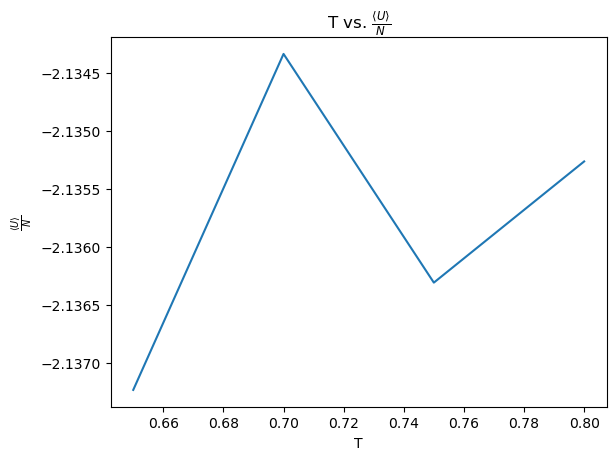

In [75]:
fig, ax = plt.subplots()
ax.plot(Ts, U_avgs)
ax.set_xlabel('T')
ax.set_ylabel(r'$\frac{\langle U \rangle}{N}$')
ax.set_title(r'T vs. $\frac{\langle U \rangle}{N}$')
plt.savefig('Visualizations/1_vi.png')

In [76]:
c_config = (U_avgs[0] - U_avgs[3]) / (Ts[0] - Ts[3])
c_config

np.float64(0.01312850702206584)

## (vii)

In [80]:
c_config_vars = [(U_var / (N * T**2)) for U_var in U_vars]
c_config_vars

[np.float64(0.005635167239434797),
 np.float64(0.006036796295217585),
 np.float64(0.006044707746702268),
 np.float64(0.006159830379847407)]

It is around half the estimaded c_config from the derivative, but they are close

# Question 2

## (i)

This is due to the increased repulsion when atoms are closer, the density of other atoms decrease drastically. 

## (ii)

Further away from r, the fluctuation of densities decrease which is due to the decreasing solvation shell packing. Eventually the organization of the solvent particles become more random and uniform at the solvent density. 

## (iii)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:31<00:00, 3210.48it/s]


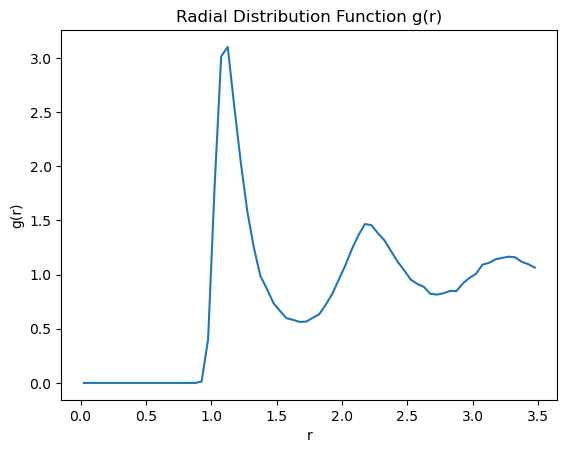

<Figure size 640x480 with 0 Axes>

In [97]:
N = 36  
T = 0.7  
density= 0.7
box_length = sqrt(N / density)
max_hop_length = 0.4
r_cut = box_length / 2
r_cut_squared = r_cut**2

r = init_config()

dr = 0.05
g_r = histogram([0, 3.5], dr)
Mconf = 0 

@jit(nopython=True)
def MC_sweep(r):
    for step in range(N):
        i_trial = int(rand() * N)
        r_trial = r[i_trial, :] + max_hop_length * (rand(2) - 0.5)

        delta_U = 0
        for j in range(N):
            if j != i_trial:
                dr_trial = r_trial - r[j, :]
                dr_trial -= box_length * floor(dr_trial / box_length + 0.5)
                dr2_trial = dr_trial @ dr_trial
                if dr2_trial < r_cut_squared:
                    delta_U += 4 * (dr2_trial**-6 - dr2_trial**-3)

                dr = r[i_trial, :] - r[j, :]
                dr -= box_length * floor(dr / box_length + 0.5)
                dr2 = dr @ dr
                if dr2 < r_cut_squared:
                    delta_U -= 4 * (dr2**-6 - dr2**-3)

        if rand() < exp(-delta_U / T):
            r[i_trial, :] = r_trial

    return r

N_sweeps = 100000  
for sweep in tqdm(range(N_sweeps)):
    r = MC_sweep(r)

    if sweep >= 500 and sweep % 100 == 0: 
        for i in range(N):
            for j in range(i + 1, N):
                dr_vec = r[i] - r[j]
                dr_vec -= box_length * floor(dr_vec / box_length + 0.5)
                distance = sqrt(dot(dr_vec, dr_vec))
                if distance < 3.5:
                    g_r.add_sample(distance)
        Mconf += 1

g_r.histo = g_r.histo / (Mconf * pi * g_r.vals * dr * (N - 1) * (N / box_length**2))


g_r.lineplot()
xlabel('r')
ylabel('g(r)')
title('Radial Distribution Function g(r)')
show()
plt.savefig('Visualizations/2_iii.png')


## (iii)

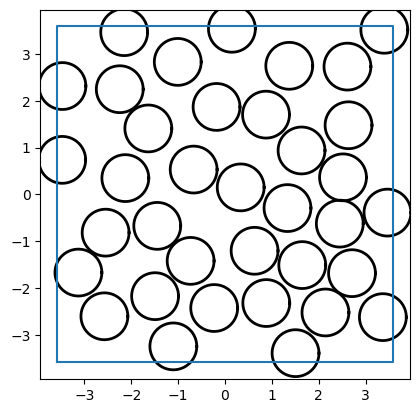

In [91]:
draw_config()

## (iv)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:30<00:00, 3244.11it/s]


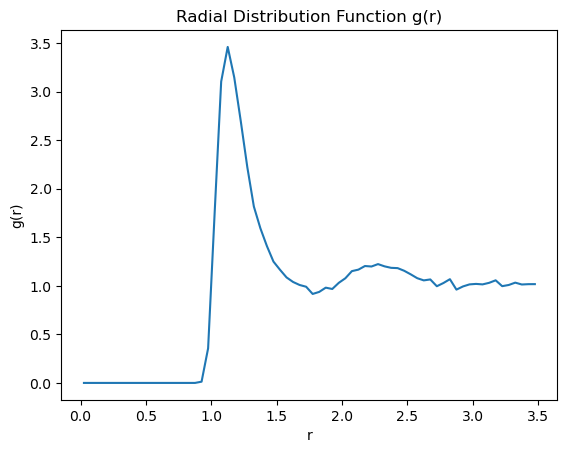

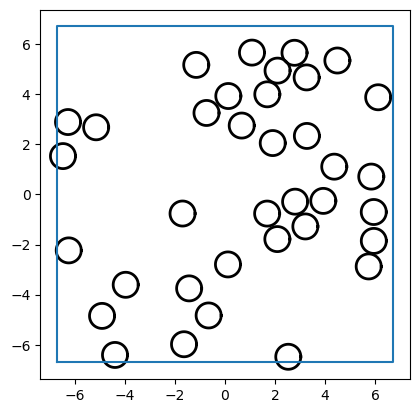

In [93]:
N = 36  
T = 0.7  
density = 0.2
box_length = sqrt(N / density)
max_hop_length = 0.4
r_cut = box_length / 2
r_cut_squared = r_cut**2

r = init_config()

dr = 0.05
g_r = histogram([0, 3.5], dr)
Mconf = 0 

@jit(nopython=True)
def MC_sweep(r):
    for step in range(N):
        i_trial = int(rand() * N)
        r_trial = r[i_trial, :] + max_hop_length * (rand(2) - 0.5)

        delta_U = 0
        for j in range(N):
            if j != i_trial:
                dr_trial = r_trial - r[j, :]
                dr_trial -= box_length * floor(dr_trial / box_length + 0.5)
                dr2_trial = dr_trial @ dr_trial
                if dr2_trial < r_cut_squared:
                    delta_U += 4 * (dr2_trial**-6 - dr2_trial**-3)

                dr = r[i_trial, :] - r[j, :]
                dr -= box_length * floor(dr / box_length + 0.5)
                dr2 = dr @ dr
                if dr2 < r_cut_squared:
                    delta_U -= 4 * (dr2**-6 - dr2**-3)

        if rand() < exp(-delta_U / T):
            r[i_trial, :] = r_trial

    return r

N_sweeps = 100000  
for sweep in tqdm(range(N_sweeps)):
    r = MC_sweep(r)

    if sweep >= 500 and sweep % 100 == 0: 
        for i in range(N):
            for j in range(i + 1, N):
                dr_vec = r[i] - r[j]
                dr_vec -= box_length * floor(dr_vec / box_length + 0.5)
                distance = sqrt(dot(dr_vec, dr_vec))
                if distance < 3.5:
                    g_r.add_sample(distance)
        Mconf += 1

g_r.histo = g_r.histo / (Mconf * pi * g_r.vals * dr * (N - 1) * (N / box_length**2))


clf()  
g_r.lineplot()
xlabel('r')
ylabel('g(r)')
title('Radial Distribution Function g(r)')
show()

draw_config()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:31<00:00, 3184.80it/s]


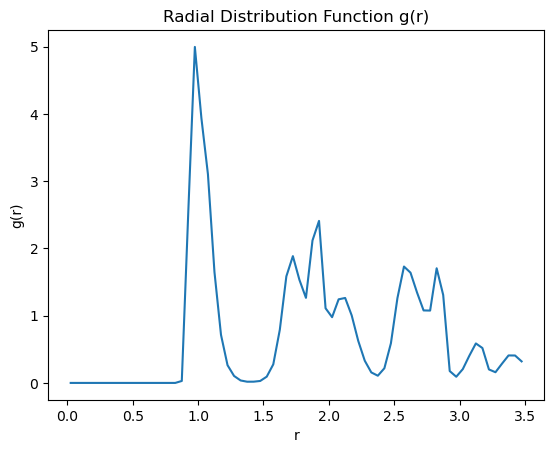

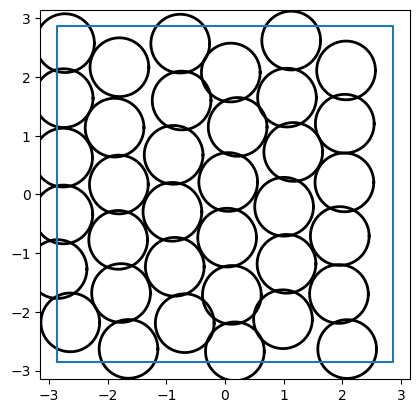

In [95]:
N = 36  
T = 0.7  
density = 1.1
box_length = sqrt(N / density)
max_hop_length = 0.4
r_cut = box_length / 2
r_cut_squared = r_cut**2

r = init_config()

dr = 0.05
g_r = histogram([0, 3.5], dr)
Mconf = 0 

@jit(nopython=True)
def MC_sweep(r):
    for step in range(N):
        i_trial = int(rand() * N)
        r_trial = r[i_trial, :] + max_hop_length * (rand(2) - 0.5)

        delta_U = 0
        for j in range(N):
            if j != i_trial:
                dr_trial = r_trial - r[j, :]
                dr_trial -= box_length * floor(dr_trial / box_length + 0.5)
                dr2_trial = dr_trial @ dr_trial
                if dr2_trial < r_cut_squared:
                    delta_U += 4 * (dr2_trial**-6 - dr2_trial**-3)

                dr = r[i_trial, :] - r[j, :]
                dr -= box_length * floor(dr / box_length + 0.5)
                dr2 = dr @ dr
                if dr2 < r_cut_squared:
                    delta_U -= 4 * (dr2**-6 - dr2**-3)

        if rand() < exp(-delta_U / T):
            r[i_trial, :] = r_trial

    return r

N_sweeps = 100000  
for sweep in tqdm(range(N_sweeps)):
    r = MC_sweep(r)

    if sweep >= 500 and sweep % 100 == 0: 
        for i in range(N):
            for j in range(i + 1, N):
                dr_vec = r[i] - r[j]
                dr_vec -= box_length * floor(dr_vec / box_length + 0.5)
                distance = sqrt(dot(dr_vec, dr_vec))
                if distance < 3.5:
                    g_r.add_sample(distance)
        Mconf += 1

g_r.histo = g_r.histo / (Mconf * pi * g_r.vals * dr * (N - 1) * (N / box_length**2))


clf()  
g_r.lineplot()
xlabel('r')
ylabel('g(r)')
title('Radial Distribution Function g(r)')
show()

draw_config()

## (vii)

Now the there isn't a clear 'shell' of particles but rather a crystal structure. 